# Implementing coordinate-transformed hermite polynomials

In [1]:
#  Automated import
import sys
import os
sys.path.append('..')

from hg_scripts.setup_imports import *


In [2]:
#order a^#*b^#
working = 4
crossterm_order = working+1

In [3]:
# 1. Mathematica solution 
mat_sol_arr = [None]*crossterm_order
for f in range(crossterm_order):
    file = open('1shift'+str(f)+".txt")

    line = file.read().replace("\n", " ")
    file.close()

#     print(line)
    print(f)
    mat_sol_arr[f] = line

mat_sol=mat_sol_arr[working]

0
1
2
3
4


In [4]:
# 2. Parse for Python

# parse solution from Mathematica FortranForm
# pars_sol=mc.mathematica(mat_sol)
# print(pars_sol)

str_pars_sol = str(mat_sol) #entire solution as string



# print(str_pars_sol.split(' '))
sol_list = str_pars_sol.split(" ") # split by whitespace



#remove '+', prepend '-'
for i in range(len(sol_list)):
    j = sol_list[i]
    if(j == '-'):
        sol_list[i+1]= '-' + sol_list[i+1]



# whitespace in Factorial(...) interferes w/ strip
## Example:
## (-8*a*b**3*p**4*z**3*Sqrt(Factorial(-4 + n)))/(3.*w**4)
## -> ["(z**3*Sqrt(Factorial(-4", "n)))/(3.*w**4)" ]
## 1) "(z**3*Sqrt(Factorial(-4" -> "(z**3*Sqrt(Factorial("
## 2) "n)))/(3.*w**4)" -> ")))/(3.*w**4)" 
## 3) -> ["(z**3*Sqrt(Factorial(n-4)))/(3.*w**4)" ]

#build list of terms, where operators +,-, whitespace deleted
sol_list[:] = [i for i in sol_list if i not in ['-', '+', '']] 

def parse_factorial(sol_list):
    for i in sol_list:
        if 'Factorial' in i:
            current_index = sol_list.index(i) #index with factorial
            next_index = current_index+1
            n_minus = 'n-' + i[-1]
            sol_list[current_index] = sol_list[current_index][:-2] + n_minus +  sol_list[next_index][1:]
            del sol_list[next_index]

parse_factorial(sol_list)

            
# print("Terms list:", sol_list)

In [5]:
#3. Separate terms list for x-coordinate dependence

#get highest n for x**n
rows, cols = (10, 10) 
sols_matrix = [ [ '' for i in range(rows) ] for j in range(cols) ]

#remove x**n and put term into sol_list[n]
for i in sol_list:
    x_order=0; p_order = 0
    #if x -> arr[n]
    #nonlinear
    if('x**' in i):
        exp_ind=i.find('x')+3 #get exp index
        x_order = int(i[exp_ind]) #set x order
    #no x -> arr[0]
    elif(not 'x' in i):
        x_order = 0
        #linear 
    else:
        x_order = 1
        
    #if x -> arr[n]
    #nonlinear
    if('p**' in i):
        exp_ind=i.find('p')+3 #get exp index
        p_order = int(i[exp_ind]) #set x order
    #no x -> arr[0]
    elif(not 'p' in i):
        p_order = 0
        #linear 
    else:
        p_order = 1
        
    sols_matrix[x_order][p_order] += '+' + i  
#     print(i,x_order,p_order)

    

    
# for row in range(rows):
#     for col in range(cols):
#         print(sols_matrix[row][col],row,col)

# print(sols_matrix)

In [6]:
waist = (1/3)*1e-3
top_modes=coeff_from_mat('paul_coef_file.mat',waist,False)



In [7]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes,s):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,s) )
                
    return(res)

In [8]:
def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave1 = 0
    time_ave2 = 0

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points
    

    #alpha_arr = np.linspace(-500e-6,500e-6,points)
    

    pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=points).start()

    
    
    for p in range(points):
        time_ave_start1 = process_time()
        #shift x+zsina
        new_modes = update_modes(v.z,v.params,v.a,v.alpha_arr[p],top_modes,sols_matrix)
        
        time_ave_start2 = process_time()
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes,v.s) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes,v.s) # right overlap (0,2e-3)
        time_ave1 += (process_time()-time_ave_start1)
        time_ave2 += (process_time()-time_ave_start2)
        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1
        
        pbar.update(p+1)
        
    pbar.finish()
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave1/p,'s',time_ave2/p,'s')
    
    return(dws,lps,total_lps)

num=11


class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=10e-3,z=10e-3,
                 z_m=0,Z=10e-3,
                 z_LO=0, d_1=10e-3,
#                  z_PD=0,z=0,
#                  z_m=0,Z=0,
#                  z_LO=0, d_1=0,
                 Y=20e-3,
                 x_1R=10e-6,x_2R=20e-3,
                 x_1L=-20e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=waist,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,0),
                 W_2=1e-3,
                 points=num,
                 a=10e-6,alpha_arr=np.linspace(-500e-6,500e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0)) #tophat beam rad , w(z) or 1e-3?
    
        self.s= (
                1/(w_1**2 *(1+(1j)*d_1/zR_1))
                +
                1/((w_2**2 *(1-(1j)*Z/zR_2)))
            )

        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
#         for p in range (points):
#             self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_matrix) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_arr) #array of array of scattered modes#array of array of scattered modes

        


Signals calculation...


100%|#########################################################################|


28.9375 s
2.89375 s 0.5890625 s


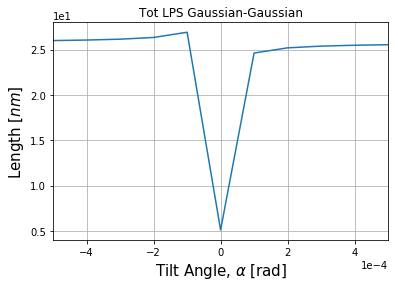

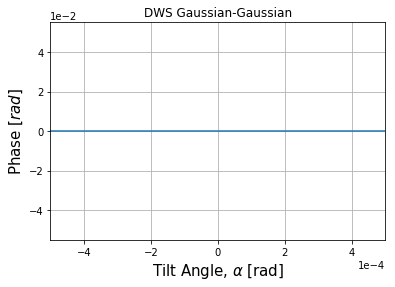

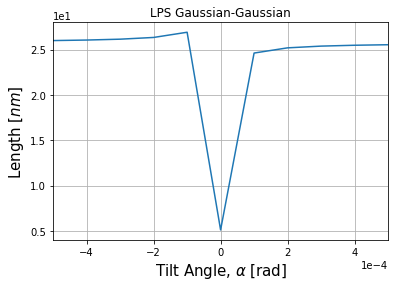

In [9]:
modes_0 = plb.modes((0,0,1))



# z=10e-3
# params = pl.Params(1064e-9,1e-3,z)


print('Signals calculation...')
v = Vars()
dws,lps,total_lps = signals(v)


params=pl.Params(1064e-9,waist,0)
K=params.getK()

total_arr = np.array(total_lps)
total_arr_con = total_arr*1e9

lps_arr = np.array(lps)
lps_arr_con = lps_arr*1e9

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'Tot LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,total_arr_con)


plt.grid()

plt.figure()

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,dws)

plt.grid()

plt.figure()



plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,lps_arr_con)


plt.grid()

In [10]:

# modes_0 = plb.modes((0,0,1))

# x=1
# I=1j

# # z=10e-3
# # params = pl.Params(1064e-9,1e-3,z)



# v = Vars()
# dws,lps,total_lps = signals(v)


# params=pl.Params(1064e-9,waist,0)
# K=params.getK()

# total_arr = np.array(total_lps)
# total_arr_con = total_arr*1e9

# lps_arr = np.array(lps)
# lps_arr_con = lps_arr*1e9

# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
# plt.title(r'Tot LPS Gaussian-Gaussian') 
# plt.xlim([-300e-6,300e-6])
# # plt.legend()
# plt.plot(v.alpha_arr,total_arr_con)


# plt.grid()

# plt.figure()

# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
# plt.title(r'DWS Gaussian-Gaussian') 
# plt.xlim([-300e-6,300e-6]); plt.ylim([-2,2])
# # plt.legend()
# plt.plot(v.alpha_arr,dws)

# plt.grid()

# plt.figure()



# plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
# plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
# plt.title(r'LPS Gaussian-Gaussian') 
# plt.xlim([-300e-6,300e-6]); plt.ylim([-5,5])
# # plt.legend()
# plt.plot(v.alpha_arr,lps_arr_con)


# plt.grid()

In [11]:
lps = lps_arr_con; total_lps = total_arr_con;

dws_slope = np.zeros(len(dws),np.float)
dws_slope[0:-1] = np.diff(dws)/np.diff(v.alpha_arr)
dws_slope[-1] = (dws[-1] - dws[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
lps_slope = np.zeros(len(lps),np.float)
lps_slope[0:-1] = np.diff(lps)/np.diff(v.alpha_arr)
lps_slope[-1] = (lps[-1] - lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
total_lps_slope = np.zeros(len(total_lps),np.float)
total_lps_slope[0:-1] = np.diff(total_lps)/np.diff(v.alpha_arr)
total_lps_slope[-1] = (total_lps[-1] - total_lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])




# ###############################################
# note = ('1_shift_'+str(working)+'_10mmoff_'+str(working)+'_'+str(working))

# scipy.io.savemat('tophat'+note+'.mat', mdict={'angle': v.alpha_arr, 'lps'+note: lps, 'total_lps'+note: total_lps,'dws_HG00'+note: dws,
#                                          'lps_slope'+note: lps_slope, 'total_lps_slope'+note : total_lps_slope,
#                                         'dws_slope'+note: dws_slope})

# print(v.alpha_arr)

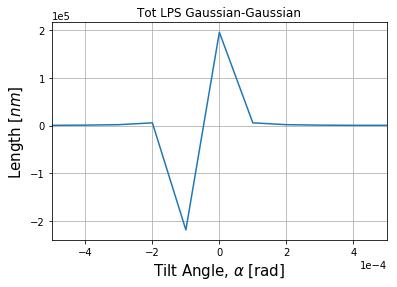

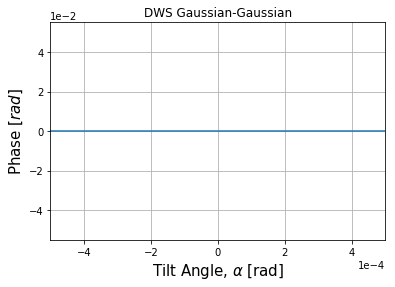

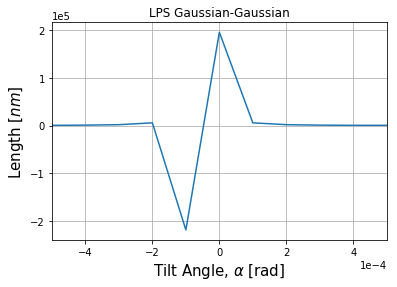

In [12]:
total_arr = np.array(total_lps)
total_arr_con = total_arr*1e9

lps_arr = np.array(lps)
lps_arr_con = lps_arr*1e9

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'Tot LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,total_lps_slope)


plt.grid()

plt.figure()

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,dws_slope)

plt.grid()

plt.figure()



plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel(r'Length $[' +  'nm]$', fontsize=15) 
plt.title(r'LPS Gaussian-Gaussian') 
plt.xlim([-500e-6,500e-6])
# plt.legend()
plt.plot(v.alpha_arr,lps_slope)


plt.grid()